<a href="https://colab.research.google.com/github/rlcoelho/mvp-qualidade/blob/master/MVP3_MeuColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Sprint: Qualidade de Software, Segurança e Sistemas Inteligentes
### Prática de Machine Learning em Python
##### Problema. Saber a qualidade do vinho a partir dos parametros

## Imports para criação e treinamento do modelo

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

%pip install seaborn

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import pickle


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Carga do Dataset

In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/RodolphoGLC/teste/refs/heads/main/winequality-red.csv"

dataset = pd.read_csv(url, delimiter=',')

dataset.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Exploração dos dados

In [3]:
def get_df_info(df, nome="DataFrame"):
    print("="*80)
    print(f"\033[1m📊 Análise do {nome}:\033[0m")
    print("="*80)

    print(f"\n🔹 \033[1mFormato:\033[0m {df.shape[0]} linhas x {df.shape[1]} colunas")
    
    print(f"\n🔹 \033[1mColunas:\033[0m {df.columns.to_list()}")

    print(f"\n🔹 \033[1mValores Nulos por Coluna:\033[0m")
    nulls = df.isnull().sum()
    nulls = nulls[nulls > 0]
    if nulls.empty:
        print("\n✅ Nenhum valor nulo encontrado.")
    else:
        print(nulls)

    print(f"\n🔹 \033[1mEstatísticas Descritivas (Numéricas):\033[0m\n")
    print(df.describe().transpose())

    print("="*80)

    # (Opcional) Visualizações rápidas - comente se não quiser
    plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10, 6))
    if dataset.isnull().sum().sum() == 0:
        print("\n✅ Nenhum valor nulo encontrado.\n")
    else:
        sns.heatmap(dataset.isnull(), cbar=False, cmap="coolwarm")
        plt.title("\nMapa de calor dos valores nulos")
        plt.show()

get_df_info(dataset)

📊 Análise do DataFrame:

🔹 Formato: 1599 linhas x 12 colunas

🔹 Colunas: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

🔹 Valores Nulos por Coluna:

✅ Nenhum valor nulo encontrado.

🔹 Estatísticas Descritivas (Numéricas):

                       count       mean        std      min      25%  \
fixed_acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
volatile_acidity      1599.0   0.527821   0.179060  0.12000   0.3900   
citric_acid           1599.0   0.270976   0.194801  0.00000   0.0900   
residual_sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
free_sulfur_dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
total_sulfur_dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
density               1599.0   0.996747   0.001887  0.99007   0.

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [4]:
# Converte em porcentagem
contagem = dataset['quality'].value_counts().sort_index()

# Contagem relativa (em %)
percentual = (contagem / contagem.sum() * 100).round(2)

# Cria um DataFrame combinado
distribuicao = pd.DataFrame({
    'quality': contagem.index,
    'quantidade': contagem.values,
    'percentual (%)': percentual.values
})

print(distribuicao.to_string(index=False))

 quality  quantidade  percentual (%)
       3          10            0.63
       4          53            3.31
       5         681           42.59
       6         638           39.90
       7         199           12.45
       8          18            1.13


## Pré Processamento e separação em conjunto de treino e conjunto de teste com holdout

Esse parte foi feita para fazer a configuração inicial, separnado nos conjuntos que vão treinar o sistema, atém de separar 20% dos dados para fins de test e ainda colocamos a parte dos parâmetros e partições da validação cruzada

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 202507 # semente aleatória

array = dataset.values

# Divide o DataFrame em (X) e (y)
X = array[:,0:11]
y = array[:,11]

# Separação em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

In [ ]:
np.random.seed(202507) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos (treinamento)
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10)) 
fig.suptitle('Comparação dos Modelos') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

Ao rodar o codigo acima, percebemos que o melhor foi o Bagging
 - Acurácia média: 0.676316
 - Desvio padrão: 0.018088
 - No boxplot: apresenta mediana alta, variância controlada e poucos outliers.

Também apresenta bons resultados nos modelos ET, RF e GB

### Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.580 (0.033)
KNN-orig: 0.496 (0.049)
CART-orig: 0.590 (0.028)
NB-orig: 0.535 (0.031)
SVM-orig: 0.500 (0.033)
Bag-orig: 0.676 (0.018)
RF-orig: 0.686 (0.034)
ET-orig: 0.678 (0.031)
Ada-orig: 0.496 (0.045)
GB-orig: 0.640 (0.038)
Vot-orig: 0.594 (0.023)
LR-padr: 0.584 (0.028)
KNN-padr: 0.564 (0.037)
CART-padr: 0.604 (0.038)
NB-padr: 0.538 (0.033)
SVM-padr: 0.613 (0.029)
Bag-padr: 0.673 (0.029)
RF-padr: 0.677 (0.025)
ET-padr: 0.684 (0.030)
Ada-padr: 0.496 (0.045)
GB-padr: 0.639 (0.037)
Vot-padr: 0.606 (0.035)
LR-norm: 0.573 (0.038)
KNN-norm: 0.555 (0.029)
CART-norm: 0.611 (0.036)
NB-norm: 0.538 (0.033)
SVM-norm: 0.597 (0.046)
Bag-norm: 0.673 (0.021)
RF-norm: 0.681 (0.025)
ET-norm: 0.689 (0.034)
Ada-norm: 0.496 (0.045)
GB-norm: 0.640 (0.034)
Vot-norm: 0.593 (0.039)


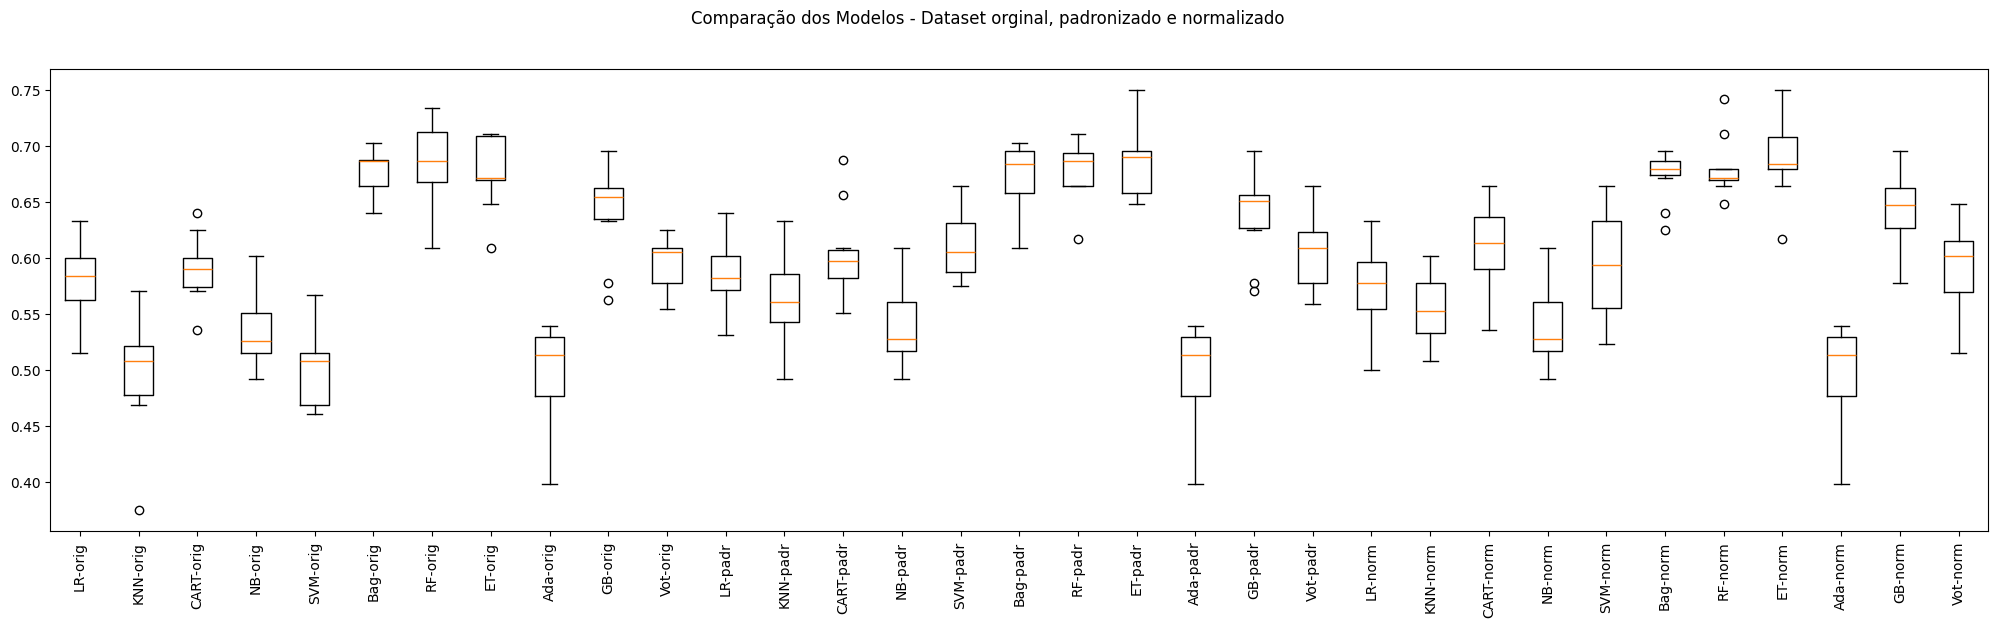

In [7]:
np.random.seed(202507) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log]))) 
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log]))) 
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging]))) 
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log]))) 
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging]))) 
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation=90)
plt.show()

Após rodar esse trecho obtive os seguintes resultados:

Tipo - Melhor Modelo - Acurácia Média (± Desvio)
 - orig - RF (Random Forest) - 0.686 ± 0.034
 - padr - ET (Extra Trees) - 0.684 ± 0.030
 - padr - Bag (Baagging) - 0.679 ± 0.019
 - norm - ET (Extra Trees) - 0.689 ± 0.034

Decidi seguir com o modelo do BaggingClassifier padr, mesmo não sendo o que teve a maior acuracia, porem teve a menor variação

Resolvi seguir por esse caminho, devido a velocidade. Pq quando testei com os outros no local acabou gerando um atraso

In [ ]:
np.random.seed(202507)  # Definindo uma semente global para este bloco

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {}
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Modelo: Bagging-orig - Melhor: 0.676317 usando {}

Os modelos depois de testar com todos os hiperparametros, pecebi que houve uma melhora com eles, porém para os casos dos Bagging, RF, ET, Ada, GB e Voting sem usar nenhum parametro ou usando acaba gerando um ganho muito pequeno e gera uma maior demora para rodar o projeto. Então visto custo (tempo x acuracia), decidi usar o mais simples para fins de facilitar no trabalho

### Otimização com hiperparâmetros

#### Otimização do AdaBoost

In [ ]:
pipeline_ada_orig = Pipeline(steps=[('Ada', AdaBoostClassifier())])
pipeline_ada_padr = Pipeline(steps=[('StandardScaler', StandardScaler()), ('Ada', AdaBoostClassifier())])
pipeline_ada_norm = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('Ada', AdaBoostClassifier())])

param_grid_ada = {
    'Ada__n_estimators': [10, 50, 100, 200],
    'Ada__learning_rate': [0.01, 0.1, 1, 10]
}

for pipeline, label in zip([pipeline_ada_orig, pipeline_ada_padr, pipeline_ada_norm], ['orig', 'padr', 'norm']):
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid_ada, scoring='accuracy', cv=5)
    grid.fit(X_train, y_train)
    print(f"Modelo: Ada-{label} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")

Testamos o modelo **AdaBoost** com três versões dos dados:

- **Ada-orig**: dados originais, sem transformação  
- **Ada-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **Ada-norm**: dados normalizados (valores entre 0 e 1)

Em todos os casos, o melhor resultado foi:

- **Score**: `0.5676`
- **Parâmetros**: `learning_rate = 0.1`, `n_estimators = 50`
- **Tempo**: 50s

📌 **Conclusão**: O desempenho do AdaBoost foi o mesmo com dados crus, padronizados ou normalizados. Isso mostra que, para este caso, o tipo de pré-processamento dos dados não influenciou o resultado final.

#### Otimização do Random Forest

In [9]:
# Random Forest
pipeline_rf_orig = Pipeline(steps=[('RF', RandomForestClassifier())])
pipeline_rf_padr = Pipeline(steps=[('StandardScaler', StandardScaler()), ('RF', RandomForestClassifier())])
pipeline_rf_norm = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('RF', RandomForestClassifier())])

param_grid_rf = {
    'RF__n_estimators': [10, 50, 100, 200],
    'RF__max_features': ['auto', 'sqrt', 'log2'],
    'RF__max_depth': [None, 10, 20, 30],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4]
}

for pipeline, label in zip([pipeline_rf_orig, pipeline_rf_padr, pipeline_rf_norm], ['orig', 'padr', 'norm']):
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid_rf, scoring='accuracy', cv=5)
    grid.fit(X_train, y_train)
    print(f"Modelo: RF-{label} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")

Modelo: RF-orig - Melhor: 0.6935 usando {'RF__max_depth': 20, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2, 'RF__n_estimators': 200}
Modelo: RF-padr - Melhor: 0.6904 usando {'RF__max_depth': 30, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 200}
Modelo: RF-norm - Melhor: 0.6927 usando {'RF__max_depth': 30, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5, 'RF__n_estimators': 100}


O modelo **Random Forest** foi testado com três variações dos dados:

- **RF-orig**: dados originais, sem transformação  
- **RF-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **RF-norm**: dados normalizados (valores entre 0 e 1)

Os melhores resultados de cada versão foram:

- **RF-orig**: `0.6935`  
  - Parâmetros: `max_depth=20`, `max_features='log2'`, `min_samples_leaf=1`, `min_samples_split=2`, `n_estimators=200`
  
- **RF-padr**: `0.6904`  
  - Parâmetros: `max_depth=30`, `max_features='log2'`, `min_samples_leaf=2`, `min_samples_split=5`, `n_estimators=200`

- **RF-norm**: `0.6927`  
  - Parâmetros: `max_depth=30`, `max_features='log2'`, `min_samples_leaf=1`, `min_samples_split=5`, `n_estimators=100`

- **Tempo**: 10m 10s

📌 **Conclusão**: O melhor desempenho foi com os **dados originais**, mas as diferenças entre as versões foram pequenas. Isso indica que o modelo Random Forest é pouco sensível ao tipo de pré-processamento aplicado aos dados neste caso.

#### Otimização do LR

In [10]:
# Otimização LR - Logistic Regression
pipeline_lr_orig = Pipeline(steps=[('LR', LogisticRegression(max_iter=200))])
pipeline_lr_padr = Pipeline(steps=[('StandardScaler', StandardScaler()), ('LR', LogisticRegression(max_iter=200))])
pipeline_lr_norm = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('LR', LogisticRegression(max_iter=200))])

param_grid_lr = {
    'LR__C': [0.01, 0.1, 1, 10, 100],
    'LR__solver': ['liblinear', 'saga']
}

for pipeline, label in zip([pipeline_lr_orig, pipeline_lr_padr, pipeline_lr_norm], ['orig', 'padr', 'norm']):
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid_lr, scoring='accuracy', cv=5)
    grid.fit(X_train, y_train)
    print(f"Modelo: LR-{label} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")

Modelo: LR-orig - Melhor: 0.5864 usando {'LR__C': 100, 'LR__solver': 'liblinear'}
Modelo: LR-padr - Melhor: 0.6005 usando {'LR__C': 0.1, 'LR__solver': 'saga'}
Modelo: LR-norm - Melhor: 0.5981 usando {'LR__C': 10, 'LR__solver': 'saga'}


O modelo **Logistic Regression** foi avaliado com três formas de tratamento dos dados:

- **LR-orig**: dados originais, sem transformação  
- **LR-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **LR-norm**: dados normalizados (valores entre 0 e 1)

Melhores resultados obtidos:

- **LR-orig**: `0.5864`  
  - Parâmetros: `C=100`, `solver='liblinear'`

- **LR-padr**: `0.6005`  
  - Parâmetros: `C=0.1`, `solver='saga'`

- **LR-norm**: `0.5981`  
  - Parâmetros: `C=10`, `solver='saga'`

- **Tempo**: 40s

📌 **Conclusão**: A melhor performance foi com **dados padronizados**, mostrando que esse tipo de pré-processamento ajuda a melhorar o desempenho da Regressão Logística. Isso faz sentido, já que o modelo é sensível à escala das variáveis.


#### Otimização do CART

In [11]:
pipeline_cart_orig = Pipeline(steps=[('CART', DecisionTreeClassifier())])
pipeline_cart_padr = Pipeline(steps=[('StandardScaler', StandardScaler()), ('CART', DecisionTreeClassifier())])
pipeline_cart_norm = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('CART', DecisionTreeClassifier())])

param_grid_cart = {
    'CART__max_depth': [None, 10, 20, 30, 40, 50],
    'CART__min_samples_split': [2, 5, 10],
    'CART__min_samples_leaf': [1, 2, 4]
}

for pipeline, label in zip([pipeline_cart_orig, pipeline_cart_padr, pipeline_cart_norm], ['orig', 'padr', 'norm']):
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid_cart, scoring='accuracy', cv=5)
    grid.fit(X_train, y_train)
    print(f"Modelo: CART-{label} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")

Modelo: CART-orig - Melhor: 0.5966 usando {'CART__max_depth': 20, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Modelo: CART-padr - Melhor: 0.6012 usando {'CART__max_depth': 40, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Modelo: CART-norm - Melhor: 0.6052 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}


O modelo **CART** foi testado com três formas de entrada dos dados:

- **CART-orig**: dados originais, sem transformação  
- **CART-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **CART-norm**: dados normalizados (valores entre 0 e 1)

Melhores resultados:

- **CART-orig**: `0.5966`  
  - Parâmetros: `max_depth=20`, `min_samples_leaf=1`, `min_samples_split=2`

- **CART-padr**: `0.6012`  
  - Parâmetros: `max_depth=40`, `min_samples_leaf=1`, `min_samples_split=2`

- **CART-norm**: `0.6052`  
  - Parâmetros: `max_depth=None`, `min_samples_leaf=1`, `min_samples_split=2`

- **Tempo**: 7s

📌 **Conclusão**: O melhor desempenho foi com **dados normalizados**, mas a diferença entre as versões foi pequena. Isso mostra que o modelo de árvore de decisão tem desempenho relativamente estável, mas pode se beneficiar de um leve pré-processamento nos dados.

#### Otimização do Bagging

In [12]:
base_estimator = DecisionTreeClassifier()
pipeline_bagging_orig = Pipeline(steps=[('Bagging', BaggingClassifier(estimator=base_estimator, n_estimators=100))])
pipeline_bagging_padr = Pipeline(steps=[('StandardScaler', StandardScaler()), ('Bagging', BaggingClassifier(estimator=base_estimator, n_estimators=100))])
pipeline_bagging_norm = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('Bagging', BaggingClassifier(estimator=base_estimator, n_estimators=100))])

# Sem parâmetros para ajustar neste caso
param_grid_bagging = {}

for pipeline, label in zip([pipeline_bagging_orig, pipeline_bagging_padr, pipeline_bagging_norm], ['orig', 'padr', 'norm']):
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid_bagging, scoring='accuracy', cv=5)
    grid.fit(X_train, y_train)
    print(f"Modelo: Bagging-{label} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")

Modelo: Bagging-orig - Melhor: 0.6623 usando {}
Modelo: Bagging-padr - Melhor: 0.6755 usando {}
Modelo: Bagging-norm - Melhor: 0.6724 usando {}


O modelo **Bagging** foi avaliado com três tipos de dados:

- **Bagging-orig**: dados originais, sem transformação  
- **Bagging-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **Bagging-norm**: dados normalizados (valores entre 0 e 1)

Melhores resultados:

- **Bagging-orig**: `0.6623`
- **Bagging-padr**: `0.6755`
- **Bagging-norm**: `0.6724`
- **Tempo**: 8s

📌 **Conclusão**: O melhor desempenho foi com **dados padronizados**, mas os resultados com dados normalizados também foram muito próximos. Isso sugere que o Bagging pode se beneficiar de um leve pré-processamento, embora funcione bem até mesmo com os dados originais.

#### Otimização do KNN

In [13]:
# Tuning do KNN

np.random.seed(202507) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Resultado: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Resultado: knn-orig - Melhor: 0.574705 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}
Resultado: knn-padr - Melhor: 0.623161 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 1}
Resultado: knn-norm - Melhor: 0.620011 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}


O modelo **KNN** foi testado com três versões dos dados:

- **KNN-orig**: dados originais, sem transformação  
- **KNN-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **KNN-norm**: dados normalizados (valores entre 0 e 1)

Melhores resultados:

- **KNN-orig**: `0.5747`  
  - Parâmetros: `n_neighbors=1`, `metric='manhattan'`

- **KNN-padr**: `0.6232`  
  - Parâmetros: `n_neighbors=1`, `metric='euclidean'`

- **KNN-norm**: `0.6200`  
  - Parâmetros: `n_neighbors=1`, `metric='manhattan'`

- **Tempo**: 5s

📌 **Conclusão**: O **melhor resultado foi com dados padronizados**, seguido de perto pelos dados normalizados. Isso reforça que o KNN depende fortemente da escala dos dados e se beneficia bastante de um bom pré-processamento.

#### Otimização do SVM

In [14]:
# Tuning do SVM

np.random.seed(202507) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__gamma': [1, 0.1, 0.01, 0.001]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Resultado: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Resultado: svm-orig - Melhor: 0.580967 usando {'SVM__C': 100, 'SVM__gamma': 0.1}
Resultado: svm-padr - Melhor: 0.646610 usando {'SVM__C': 1, 'SVM__gamma': 1}
Resultado: svm-norm - Melhor: 0.598899 usando {'SVM__C': 100, 'SVM__gamma': 1}


O modelo **SVM** foi testado com três versões dos dados:

- **SVM-orig**: dados originais, sem transformação  
- **SVM-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **SVM-norm**: dados normalizados (valores entre 0 e 1)

Melhores resultados:

- **SVM-orig**: `0.5810`  
  - Parâmetros: `C=100`, `gamma=0.1`

- **SVM-padr**: `0.6466`  
  - Parâmetros: `C=1`, `gamma=1`

- **SVM-norm**: `0.5989`  
  - Parâmetros: `C=100`, `gamma=1`

- **Tempo**: 23s

📌 **Conclusão**: O melhor resultado foi com **dados padronizados**, mostrando que o SVM é bastante sensível à escala das variáveis. Com o pré-processamento adequado, o desempenho melhora significativamente.

#### Otimização do Naive Bayes

In [15]:
# Tuning do Gaussian Naive Bayes

np.random.seed(202507) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
nb = ('NB', GaussianNB())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('nb-orig', Pipeline(steps=[nb])))
pipelines.append(('nb-padr', Pipeline(steps=[standard_scaler, nb])))
pipelines.append(('nb-norm', Pipeline(steps=[min_max_scaler, nb])))

param_grid = {
    'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Resultado: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Resultado: nb-orig - Melhor: 0.551193 usando {'NB__var_smoothing': 1e-05}
Resultado: nb-padr - Melhor: 0.537906 usando {'NB__var_smoothing': 1e-09}
Resultado: nb-norm - Melhor: 0.537906 usando {'NB__var_smoothing': 1e-09}


O modelo **Naive Bayes** foi testado com três tipos de dados:

- **NB-orig**: dados originais, sem transformação  
- **NB-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **NB-norm**: dados normalizados (valores entre 0 e 1)

Melhores resultados:

- **NB-orig**: `0.5512`  
  - Parâmetros: `var_smoothing=1e-5`

- **NB-padr**: `0.5379`  
  - Parâmetros: `var_smoothing=1e-9`

- **NB-norm**: `0.5379`  
  - Parâmetros: `var_smoothing=1e-9`

- **Tempo**: 1s

📌 **Conclusão**: O melhor desempenho foi com os dados originais. O Naive Bayes parece ser pouco beneficiado pelo pré-processamento de padronização ou normalização neste conjunto de dados.

#### Otimização da Árvore de Decisão

In [16]:
# Tuning da Árvore de Decisão
# Utilizando hiperparâmetros: criterion, max_depth, min_samples_split, min_samples_leaf, max_features

# Melhor Resultado: cart-norm - Melhor: 0.623930 usando {'CART__criterion': 'gini', 'CART__max_depth': 50, 'CART__max_features': 'sqrt', 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}

np.random.seed(202507) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
cart = ('CART', DecisionTreeClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('cart-orig', Pipeline(steps=[cart])))
pipelines.append(('cart-padr', Pipeline(steps=[standard_scaler, cart])))
pipelines.append(('cart-norm', Pipeline(steps=[min_max_scaler, cart])))

param_grid = {
    'CART__criterion': ['gini', 'entropy'],
    'CART__max_depth': [None, 10, 20, 30, 40, 50],
    'CART__min_samples_split': [2, 5, 10],
    'CART__min_samples_leaf': [1, 2, 4],
    'CART__max_features': [None, 'sqrt', 'log2']
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Resultado: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Resultado: cart-orig - Melhor: 0.609849 usando {'CART__criterion': 'entropy', 'CART__max_depth': 50, 'CART__max_features': 'log2', 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Resultado: cart-padr - Melhor: 0.616929 usando {'CART__criterion': 'entropy', 'CART__max_depth': None, 'CART__max_features': 'sqrt', 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Resultado: cart-norm - Melhor: 0.623930 usando {'CART__criterion': 'gini', 'CART__max_depth': 50, 'CART__max_features': 'sqrt', 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}


O modelo **CART** foi testado com três versões dos dados e com mais parâmetros ajustados:

- **CART-orig**: dados originais, sem transformação  
- **CART-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **CART-norm**: dados normalizados (valores entre 0 e 1)

Melhores resultados:

- **CART-orig**: `0.6098`  
  - Parâmetros: `criterion='entropy'`, `max_depth=50`, `max_features='log2'`, `min_samples_leaf=1`, `min_samples_split=2`

- **CART-padr**: `0.6169`  
  - Parâmetros: `criterion='entropy'`, `max_depth=None`, `max_features='sqrt'`, `min_samples_leaf=1`, `min_samples_split=2`

- **CART-norm**: `0.6239`  
  - Parâmetros: `criterion='gini'`, `max_depth=50`, `max_features='sqrt'`, `min_samples_leaf=1`, `min_samples_split=2`

- **Tempo**: 50s

📌 **Conclusão**: O melhor desempenho foi com os **dados normalizados** e o critério `gini`. Os ajustes adicionais nos hiperparâmetros como `criterion` e `max_features` contribuíram para melhorar o resultado, mostrando que a escolha dos parâmetros é importante para o desempenho do modelo.

#### Otimização do Voting Classifier

In [17]:
estimators = [
    ('logistic', LogisticRegression(max_iter=200)),
    ('cart', DecisionTreeClassifier()),
    ('svm', SVC())
]

pipeline_voting_orig = Pipeline(steps=[('Voting', VotingClassifier(estimators=estimators, voting='hard'))])
pipeline_voting_padr = Pipeline(steps=[('StandardScaler', StandardScaler()), ('Voting', VotingClassifier(estimators=estimators, voting='hard'))])
pipeline_voting_norm = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('Voting', VotingClassifier(estimators=estimators, voting='hard'))])

# VotingClassifier geralmente não tem parâmetros próprios úteis para otimização nesse contexto
param_grid_voting = {}

for pipeline, label in zip([pipeline_voting_orig, pipeline_voting_padr, pipeline_voting_norm], ['orig', 'padr', 'norm']):
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid_voting, scoring='accuracy', cv=5)
    grid.fit(X_train, y_train)
    print(f"Modelo: Voting-{label} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")

Modelo: Voting-orig - Melhor: 0.5825 usando {}
Modelo: Voting-padr - Melhor: 0.6161 usando {}
Modelo: Voting-norm - Melhor: 0.5942 usando {}


O modelo **Voting** foi testado com três versões dos dados:

- **Voting-orig**: dados originais, sem transformação  
- **Voting-padr**: dados padronizados (média 0 e desvio padrão 1)  
- **Voting-norm**: dados normalizados (valores entre 0 e 1)

Melhores resultados:

- **Voting-orig**: `0.5825`
- **Voting-padr**: `0.6161`
- **Voting-norm**: `0.5942`
- **Tempo**: 1s

📌 **Conclusão**: O melhor desempenho foi obtido com dados padronizados, indicando que o pré-processamento pode ajudar a melhorar a combinação de modelos no Voting Classifier.

## Finalização do Modelo

Este código realiza o treinamento e avaliação de um modelo de **Bagging** com árvores de decisão, utilizando **StandardScaler** para padronizar os dados.

**Passos principais:**

1. **Padronização dos dados**:  
   O `StandardScaler` é ajustado (`fit`) nos dados de treino (`X_train`) para aprender a média e desvio padrão.  
   Depois, ele transforma (`transform`) tanto os dados de treino quanto os de teste, aplicando a padronização.

2. **Criação e treinamento do modelo**:  
   Um modelo de `BaggingClassifier` com 100 árvores de decisão (`DecisionTreeClassifier`) é criado e treinado usando os dados padronizados de treino.

3. **Avaliação do modelo**:  
   O modelo faz previsões nos dados padronizados de teste (`scaledX_test`) e a acurácia é calculada para medir o desempenho.

---

Esse processo garante que o modelo receba dados com escalas semelhantes, o que pode ajudar a melhorar a performance, especialmente em algoritmos sensíveis à escala dos dados.

In [18]:
scaler = StandardScaler().fit(X_train)

# Aplicar o scaler nos dados
scaledX_train = scaler.transform(X_train)
scaledX_test = scaler.transform(X_test)

# Criar o modelo Bagging com DecisionTree como base
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)
model.fit(scaledX_train, y_train)

# Fazer predições e avaliar
predictions = model.predict(scaledX_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Acurácia no conjunto de teste (Bagging com StandardScaler): {accuracy:.6f}")

Acurácia no conjunto de teste (Bagging com StandardScaler): 0.721875


In [19]:
# Preparação do modelo com TODO o dataset
model.fit(X, y)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)

### Salvando o arquivo pkl como um Pipeline contendo o modelo e o scaler

In [20]:
# Criar pipeline com scaler e modelo
pipeline = Pipeline(steps=[
    ('StandardScaler', StandardScaler()),
    ('Bagging', model)
])

# Treinar pipeline
pipeline.fit(X_train, y_train)

# Fazer predições e avaliar
predictions = model.predict(scaledX_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Acurácia no conjunto de teste (Bagging com StandardScaler): {accuracy:.6f}")


Acurácia no conjunto de teste (Bagging com StandardScaler): 0.703125


In [37]:
# Salvar o modelo
model_filename = 'bag_wine_model.pkl'
with open("../models/" + model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvar o scaler
scaler_filename = 'scaler_wine.pkl'
with open("../scalers/" + scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Salvar o pipeline (scaler + modelo)
pipeline_filename = 'pipeline_wine_svm.pkl'
with open("../pipelines/" + pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)